# Read and Visualize a WSI
Click to open in: [[GitHub](https://github.com/TissueImageAnalytics/tiatoolbox/tree/master/examples/01-wsi-reading.ipynb)][[Colab](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/master/examples/01-wsi-reading.ipynb)]

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory. To connect with Colab, click on one of the two blue checkboxes above. Check that "colab" appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on GitHub or Colab, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab, set up your Python environment, as explained in the
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.

### About this demo

This demo reads a whole slide image (WSI) using tiatoolbox. We load a sample WSI, gather some key information, and then extract some image patches. We demo our modules
`wsireader` [details](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/tiatoolbox/wsicore/wsireader.py) and
`slide_info` [details](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/tiatoolbox/wsicore/slide_info.py).

## Setting up the environment
### TIAToolbox and dependencies installation
You can skip the following cell if 1) you are not using the Colab plaform or 2) you are using Colab and this is not your first run of the notebook in the current runtime session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab , the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail -n 1
!pip install tiatoolbox | tail -n 1

print("Installation is done.")

**IMPORTANT**: If you are using Colab and you run the cell above for the first time, please note that you need to restart the runtime before proceeding through (menu) *Runtime&#8594;Restart runtime* . This is needed to load the latest versions of prerequisite packages installed with TIAToolbox. Doing so, you should be able to run all the remaining cells altogether (*Runtime&#8594;Run after* from the next cell) or one by one.

### Removing leftovers from previous runs
The cell below removes the directory `tmp` if it exists—a previous run may have created it. This cell can be skipped if you are running this notebook for the first time.

In [2]:
![ -d tmp ] && ( echo "deleting tmp directory"; rm -rf tmp )

### Importing related libraries

We import some standard Python modules, and also the Python module `wsireader` (see [details](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/tiatoolbox/wsicore/wsireader.py)) written by the TIA Centre team.

In [3]:
from tiatoolbox.wsicore.wsireader import WSIReader
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 150  # for high resolution figure in notebook

|2022-08-14|16:09:33.199| [WARNING] /Users/dbae/opt/miniconda3/envs/tiatoolbox-dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## Reading in a WSI

We load a small WSI, specified with the help of the path variable `user_sample_wsi_path` (default value `None`). Unless this None value is changed, the WSI is downloaded from the web, as seen in the code below, and saved with filename given by the variable `sample_file_name` in the directory given by `data_dir`. Data generated by the notebook is stored under data_dir, providing rapid local access.

In [4]:
data_dir = "./tmp"
sample_file_name = "sample_wsi_small.svs"

user_sample_wsi_path = None

if user_sample_wsi_path is None:
    sample_wsi_path = "%s/%s" % (data_dir, sample_file_name)
else:
    sample_wsi_path = user_sample_wsi_path
if not os.path.exists(sample_wsi_path):
    os.mkdir(data_dir)
    r = requests.get(
        " https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/CMU-1-Small-Region.svs"
    )
    with open(sample_wsi_path, "wb") as f:
        f.write(r.content)

Our code shields the user from the incompatible formats produced by different models of scanners from different vendors. The function `WSIReader.open` has as input a particular WSI, with a particular image format, and outputs an object `wsi_reader_v1`, whose base class is `WSIReader`, and whose derived class depends on the image format ([see details](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/tiatoolbox/wsicore/wsireader.py)). The reader `wsi_reader_v1` provides important information about the WSI. Member functions obtain pixel- or patch-level information, using format-independent code, as we illustrate below.

In [5]:
wsi_reader_v1 = WSIReader.open(input_img=sample_wsi_path)
print(type(wsi_reader_v1))

<class 'tiatoolbox.wsicore.wsireader.OpenSlideWSIReader'>


First, let's check the basic WSI information, such as magnification, dimension, etc.
(`mpp` = microns per pixel).

In [6]:
wsi_info = wsi_reader_v1.info.as_dict()
# Print one item per line
print(*list(wsi_info.items()), sep="\n")

('objective_power', 20.0)
('slide_dimensions', (2220, 2967))
('level_count', 1)
('level_dimensions', ((2220, 2967),))
('level_downsamples', [1.0])
('vendor', 'aperio')
('mpp', (0.499, 0.499))
('file_path', PosixPath('tmp/sample_wsi_small.svs'))


### Thumbnail

To see a thumbnail of the WSI, we use the `slide_thumbnail` method of `wsi_reader_v1`.
We load the thumbnail at $\times1.25$ objective power as follows:

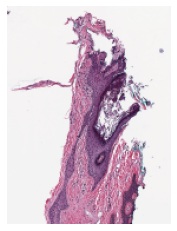

In [7]:
wsi_thumb = wsi_reader_v1.slide_thumbnail(resolution=1.25, units="power")
plt.imshow(wsi_thumb)
plt.axis("off")
plt.show()

## Reading WSI regions

### i) Read Rect

We can read a region of the whole slide image at a given location and size using the `read_rect` method. Location can be stated as (x, y) tuple giving the top left pixel in the baseline (level 0) reference frame, and size as (width, height) tuple giving the desired output image size.

Reads can be performed at different resolutions by supplying a pair of arguments for the `resolution` and the `units` of resolution. `resolution` can be given as integer or float or tuple(float), default = 0. Either a single number or a sequence of two numbers for x and y as tuple are valid. This value is in terms of the corresponding units. For example: resolution=0.5 and units=''mpp'' will read the slide at 0.5 microns per-pixel, and resolution=3, units=''level'' will read at level at pyramid level / resolution layer 3. Supported units are: microns per pixel (''mpp''), objective power (''power''), pyramid / resolution level (''level''), pixels per baseline pixel (''baseline''), default =''level''.


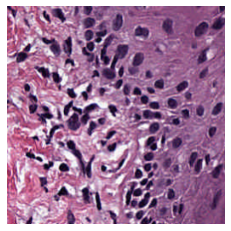

In [8]:
# location coordinates in (x,y)
location = (1000, 1000)

# size of the region in (width, height)
size = (256, 256)

# read the region using wsi reader's read rect at 0.5 mpp
img = wsi_reader_v1.read_rect(
    location,
    size,
    resolution=0.5,
    units="mpp",
)

plt.imshow(img)
plt.axis("off")
plt.show()

### ii) Read bound


Read a region of the whole slide image within given bounds. Bounds is a tuple of (start_x, start_y, end_x, end_y) i.e., (left, top, right, bottom) of the region in baseline reference frame. However, with coord_space=''resolution'', the bound is expected to be at the requested `resolution` system.

Reads can be performed at different resolutions by supplying a pair of arguments for the resolution and the units of resolution. resolution can be given as integer or float or tuple(float), default = 0. Either a single number or a sequence of two numbers for x and y as tuple are valid. This value is in terms of the corresponding units. For example: resolution=0.5 and units=''mpp'' will read the slide at 0.5 microns per-pixel, and resolution=3, units=''level'' will read at level at pyramid level / resolution layer 3. Supported units are: microns per pixel (''mpp''), objective power (''power''), pyramid / resolution level (''level''), pixels per baseline pixel (''baseline''), default =''level''.

coord_space = ''baseline'' by default, this is a flag to indicate if the input bounds is in the baseline coordinate system (''baseline'') or is in the requested resolution system (''resolution'').






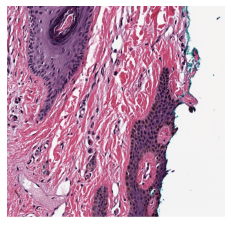

In [9]:
# specify the bounds in terms of rectangle (left, top, right, bottom)
bounds = [1000, 2000, 2000, 3000]

# read the region using wsi reader's read bounds at level 0
img = wsi_reader_v1.read_bounds(bounds, resolution=0, units="level")

plt.imshow(img)
plt.axis("off")
plt.show()

## A Mask

Over the next several cells, we will use the `WSIReader` object to help create a collection of patches covering the tissue area, with limited overlapping. We want to be able to visualise these patches at the high resolution of the original WSI, but it is computationally more efficient to work as much as possible with the much smaller low resolution thumbnail.

The first task is to distinguish between tissue and glass (no tissue) in the image. We compute a *mask*, by which we mean a binary colouring of the pixels to either black=glass or white=tissue. The white area is deliberately made a little larger than tissue area, as this will be appropriate for our task. Our function `simple_get_mask` binarises the thumbnail on the basis of pixel intensity, using the Otsu method. Morphological operations improve the result.

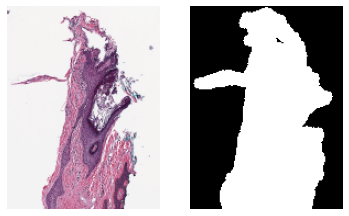

In [10]:
import math, cv2
from skimage import morphology

# an example function using intensity thresholding and morphological operations to obtain tissue regions
def simple_get_mask(rgb):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(
        gray, 0, 255, cv2.THRESH_OTSU
    )  # threshold using the OTSU method
    mask = morphology.remove_small_objects(mask == 0, min_size=100, connectivity=2)
    mask = morphology.remove_small_holes(mask, area_threshold=100)
    mask = morphology.binary_dilation(mask, morphology.disk(5))
    return mask


# plot thumbnail (left) with its tissue mask (right)
wsi_thumb_mask = simple_get_mask(wsi_thumb)
plt.subplot(1, 2, 1)
plt.imshow(wsi_thumb)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(wsi_thumb_mask, cmap="gray")
plt.axis("off")
plt.show()

### Extracting patches 1: Superpixels and `SLIC`

We wish to extract patches from our WSI. We will construct a set of patches covering the tissue region, without too much overlap. This will be achieved using the *SLIC* algorithm, described [here](https://darshita1405.medium.com/superpixels-and-slic-6b2d8a6e4f08). Our implementation is `slic` from `skimage`. This program segments the tissue region into disjoint **superpixels**. A superpixel is, by definition, an irregularly shaped, connected union of pixels with common traits, the traits being chosen according to the problem. In `SLIC`, each superpixel consists of pixels that are near each other in the 2d plane of the image, and are also near (or as near as possible, given the various constraints) to each other in 3d colour space. Pixels cluster according to these traits, while, simultaneously, the program aims for a certain number of superpixels (specified by `nr_expected_superpixels`, one of the arguments to `slic`). The result is a collection of superpixels, each superpixel having approximately the same area. The `numpy` array `wsi_superpixels_mask`, output by `slic`, has the same shape as `wsi_thumb_mask`. The $N$ superpixels are numbered $1,2...N-1, N$. Each low resolution pixel in the $i$-th superpixel corresponds to an entry $i$ in the array, and each pixel that is not in any superpixel corresponds to a zero entry.

In [11]:
from scipy.ndimage.measurements import center_of_mass
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

lores_mag = 1.25  # thumbnail objective power (lores = low resolution)
hires_mag = 20  # original WSI objective power (hires = high resolution)
hires_patch_size = 128  # 128x128 original WSI pixels
# map patch size at hires to lores
lores_patch_size = int(hires_patch_size / (hires_mag / lores_mag))
nr_expected_superpixels = math.ceil(np.sum(wsi_thumb_mask) / (lores_patch_size**2))

wsi_superpixels_mask = slic(
    wsi_thumb,
    mask=wsi_thumb_mask,
    n_segments=nr_expected_superpixels,
    compactness=1000,
    sigma=1,
)

print(
    "#Actual Patches / #Expected Patches : %d/%d"
    % (np.unique(wsi_superpixels_mask).shape[0], nr_expected_superpixels)
)

|2022-08-14|16:09:39.979| [WARNING] /var/folders/f2/pyj3khtr8xj8vr0059_y9lvh0000gp/T/ipykernel_55885/4129471504.py:1: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass



#Actual Patches / #Expected Patches : 203/202



In the image below, the position of each superpixel is made clear by marking the boundary in yellow. Each centre of mass (blue dot in the image below) of each superpixel is used as the centre of a new square patch. The algorithm encourages the centres to arrange themselves, where possible, in the pattern of a square grid, usually tilted. The patches are all the same size, and they cover the tissue area. They may overlap, but the overlap is limited. To locate these centres, we need a coordinate system. The algorithm encourages the centres to arrange themselves roughly in the pattern of a square grid, usually tilted. Instead of the familiar `(x,y)` coordinates, we use `(row,column)` coordinates because our data is held in arrays. The origin is at the top-left of the image, and the first coordinate increases as one moves down. Up to this point, we have worked at low resolution for computational efficiency. But examination of each patch in detail requires the use of high resolution data, and we change coordinates accordingly.

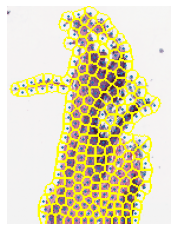

In [12]:
lores_superpixels_center = center_of_mass(
    wsi_superpixels_mask,
    labels=wsi_superpixels_mask,
    index=np.unique(wsi_superpixels_mask)[1:],
)  # omit zeros–they correspond to pixels not in any superpx
lores_superpixels_center = np.array(
    lores_superpixels_center
)  # coordinates Y,X because 2d-array uses row,col
lores_superpixels_center = lores_superpixels_center.astype(np.int32)
selected_indices = wsi_thumb_mask[
    lores_superpixels_center[:, 0], lores_superpixels_center[:, 1]
]
lores_superpixels_center = lores_superpixels_center[selected_indices]

# show the patches region and their centres of mass
plt.imshow(mark_boundaries(wsi_thumb, wsi_superpixels_mask))
plt.scatter(lores_superpixels_center[:, 1], lores_superpixels_center[:, 0], s=2)
plt.axis("off")
plt.show()

We then convert the centres of each region to the top-left position of the patches at high resolution.

In [13]:
# convert to top left idx at hires_mag level
lores_superpixels_top_left = lores_superpixels_center - (lores_patch_size // 2)
hires_superpixels_top_left = lores_superpixels_top_left * (hires_mag / lores_mag)
hires_superpixels_top_left = hires_superpixels_top_left.astype(np.int32)

We will now load some patches for visualisation.

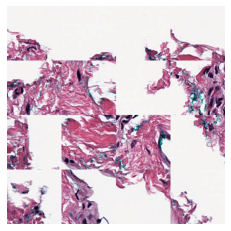

In [14]:
nr_viz_patches = 16

# for illustration purpose, we only visualise a small number of examples
selected_indices = np.random.randint(
    0, hires_superpixels_top_left.shape[0], size=(4 * nr_viz_patches,)
)
hires_superpixel_top_left = hires_superpixels_top_left[selected_indices]

patch_list = []
for patch_coord in hires_superpixels_top_left:
    patch = wsi_reader_v1.read_region(
        location=patch_coord[::-1], level=0, size=hires_patch_size
    )
    patch_list.append(patch)

# plot the first 16
sub_patches = np.array(patch_list[:16])
sub_patches = np.reshape(sub_patches, (4, 4, hires_patch_size, hires_patch_size, 3))
sub_patches = np.transpose(sub_patches, (0, 2, 1, 3, 4))
sub_patches = np.reshape(sub_patches, (4 * hires_patch_size, 4 * hires_patch_size, 3))
plt.imshow(sub_patches)
plt.axis("off")
plt.show()

If you want to extract the entire WSI (including the background), you can use the built-in `save_tiles` functionality of the `WSIReader` object.

We start by creating another `WSIReader` object and then save tiles using the `save_tiles` function with the keywords `tile_objective_value`, `tile_read_size` and `output_dir`. These correspond to the magnification set for reading patches, their expected width & height and the output destination. The word **tile** refers to a very large image patch. Here, tiles are read at 20x objective magnification, each of size $1000\times1000$, and will be saved in the `data_dir`.

In [15]:
# create a file handler
wsi_reader_v2 = WSIReader.open(input_img=sample_wsi_path)
wsi_reader_v2.save_tiles(
    output_dir=data_dir + "/output/",
    tile_objective_value=20,
    tile_read_size=(1000, 1000),
)

Tile0:  start_w:0, end_w:1000, start_h:0, end_h:1000, width:1000, height:1000
Tile1:  start_w:1000, end_w:2000, start_h:0, end_h:1000, width:1000, height:1000
Tile2:  start_w:2000, end_w:2220, start_h:0, end_h:1000, width:220, height:1000
Tile3:  start_w:0, end_w:1000, start_h:1000, end_h:2000, width:1000, height:1000
Tile4:  start_w:1000, end_w:2000, start_h:1000, end_h:2000, width:1000, height:1000
Tile5:  start_w:2000, end_w:2220, start_h:1000, end_h:2000, width:220, height:1000
Tile6:  start_w:0, end_w:1000, start_h:2000, end_h:2967, width:1000, height:967
Tile7:  start_w:1000, end_w:2000, start_h:2000, end_h:2967, width:1000, height:967
Tile8:  start_w:2000, end_w:2220, start_h:2000, end_h:2967, width:220, height:967


We check the content of the output folder and visualize some tiles. The extracted tiles are saved in the directory `{data_dir}/output/{sample_file_name}`. The folder contains `Output.csv` summarizing the extracted tiles.

In [16]:
import pandas as pd

tile_summary = pd.read_csv(
    "{data_dir}/output/{sample_file_name}/Output.csv".format(
        data_dir=data_dir, sample_file_name=sample_file_name
    )
)
print(tile_summary)

   iter              Tile_Name  start_w  end_w  start_h  end_h  size_w  size_h
0     0        Tile_20_0_0.jpg        0   1000        0   1000    1000    1000
1     1     Tile_20_1000_0.jpg     1000   2000        0   1000    1000    1000
2     2     Tile_20_2000_0.jpg     2000   2220        0   1000    1000     220
3     3     Tile_20_0_1000.jpg        0   1000     1000   2000    1000    1000
4     4  Tile_20_1000_1000.jpg     1000   2000     1000   2000    1000    1000
5     5  Tile_20_2000_1000.jpg     2000   2220     1000   2000    1000     220
6     6     Tile_20_0_2000.jpg        0   1000     2000   2967     967    1000
7     7  Tile_20_1000_2000.jpg     1000   2000     2000   2967     967    1000
8     8  Tile_20_2000_2000.jpg     2000   2220     2000   2967     967     220


We plot `Tile_20_1000_1000.jpg` as an example.

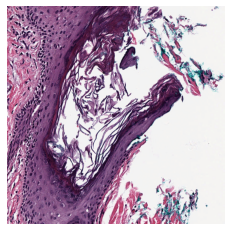

In [17]:
sample_tile = cv2.imread(
    "%s/output/%s/%s" % (data_dir, sample_file_name, tile_summary.iloc[4]["Tile_Name"])
)
sample_tile = cv2.cvtColor(sample_tile, cv2.COLOR_BGR2RGB)

plt.imshow(sample_tile)
plt.axis("off")
plt.show()

If you think that patch extraction is too complex a task, don't worry. There are some powerful tools in the Tiatoolbox that can help you automatically extract patches from WSIs at your desired resolution, size, and stride with only one line of code. Please refer to `04_example_patchextraction.ipynb` example notebook for more information.

## jp2 format

The base class `WSIReader` also contains a derived class for WSIs in `jp2` format (see above for more details).We will briefly illustrate this by downloading a `jp2` WSI from the internet and visualizing its thumbnail.

<class 'tiatoolbox.wsicore.wsireader.OmnyxJP2WSIReader'>


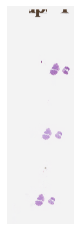

In [18]:
sample_wsi_path = "%s/sample_jp2.jp2" % data_dir
if not os.path.exists(sample_wsi_path):
    r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/test1.jp2")
    with open(sample_wsi_path, "wb") as f:
        f.write(r.content)

wsi_reader_v3 = WSIReader.open(input_img=sample_wsi_path)
print(type(wsi_reader_v3))
wsi_thumb = wsi_reader_v3.slide_thumbnail(resolution=1.25, units="power")
plt.imshow(wsi_thumb)
plt.axis("off")
plt.show()